# Text Analytics using Druglib Data:
 This is a high level illustration about the labelled data available  in public domain.
### Data:
 Source : UCI Machine Learning Repository
### Brief Description : 
 This data has altogether eight columns of interest. Specifically three if we say about the feature variable available in it. all the review related fields available in the data. All of them are textual fields. We will do a some analysis and try to predict all three labelled(strictly categorical) data available in the dataset which are respectively 'rating', 'effectiveness' and 'sideEffects'.
 
 As of now, we will only concentrate on predicting effectiveness with the help of the benefitreview text field available in the data set. 

In [20]:
##necessary module imports

%matplotlib inline
import numpy as np
import re
import string
import nltk
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2

## Reading in Data

In [3]:
#data import
train_data = pd.read_csv("drugLibTrain_raw.tsv", sep='\t', usecols=[3,6])
train_data['benefitsReview'] = train_data['benefitsReview'].astype('str')
test_data = pd.read_csv("drugLibTest_raw.tsv", sep='\t', usecols=[3,6])
test_data['benefitsReview'] = test_data['benefitsReview'].astype('str')

## Basic Preprocessing

In accordance with NLP problem solving paradigm, we will be doing some basic preprocessing of text data, such as,
1. Removing Punctuation
2. Removing Numerical Figures
3. Removing Stopwords
4. Obtaining Lemmma of the vocabulary

In [4]:
# import stopwords
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
#defining a function for text preprocessing
def clean_text(text):
    text1 = "".join([word for word in text if word not in string.punctuation])
    text2 = re.sub('\d+', '', text1)
    tokens = re.split('\W+', text2)
    text3 = [word for word in tokens if word not in stopwords]
    text4 = [wn.lemmatize(word) for word in text3]
    finaltext = " ".join(text for text in text4)
    return finaltext

In [6]:
#applying text cleaning function in the text field
train_data['benefitsReview_lemma'] = train_data['benefitsReview'].apply(lambda x: clean_text(x.lower()))
test_data['benefitsReview_lemma'] = test_data['benefitsReview'].apply(lambda x: clean_text(x.lower()))

In [7]:
train_data.head()

,effectiveness,benefitsReview,benefitsReview_lemma
0,Highly Effective,slowed the progression of left ventricular dys...,slowed progression left ventricular dysfunctio...
1,Highly Effective,Although this type of birth control has more c...,although type birth control con pro help cramp...
2,Highly Effective,I was used to having cramps so badly that they...,used cramp badly would leave balled bed least ...
3,Marginally Effective,The acid reflux went away for a few months aft...,acid reflux went away month day drug heartburn...
4,Marginally Effective,I think that the Lyrica was starting to help w...,think lyrica starting help pain sideeffects se...


# Distribution of Data

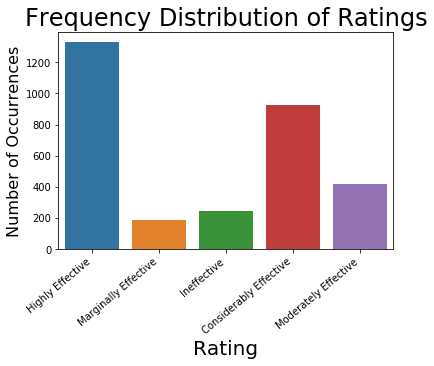

In [9]:
#plot for ratings

view = sns.countplot(x="effectiveness", data=train_data)
view.set_xticklabels(view.get_xticklabels(), rotation=40, ha="right")
plt.title('Frequency Distribution of Ratings', fontsize = 24)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Rating', fontsize=20)
plt.show()

## Converting Categorical Rating data into Binary Classes

We will convert five rating classes into binary classes of effective and ineffective. We will consider, "Highly Effective", "Considerably Effective","Moderately Effective", these three classes as effective and "Marginally Effective", "Ineffective" as ineffective.

In [10]:
cleanup_nums = {"effectiveness": {"Highly Effective": 1, "Considerably Effective": 1,"Moderately Effective": 1, 
                                  "Marginally Effective": 0, "Ineffective": 0}}
train_data.replace(cleanup_nums, inplace=True)
test_data.replace(cleanup_nums, inplace=True)

In [11]:
train_data.head()

,effectiveness,benefitsReview,benefitsReview_lemma
0,1,slowed the progression of left ventricular dys...,slowed progression left ventricular dysfunctio...
1,1,Although this type of birth control has more c...,although type birth control con pro help cramp...
2,1,I was used to having cramps so badly that they...,used cramp badly would leave balled bed least ...
3,0,The acid reflux went away for a few months aft...,acid reflux went away month day drug heartburn...
4,0,I think that the Lyrica was starting to help w...,think lyrica starting help pain sideeffects se...


## Frequency Distribution 

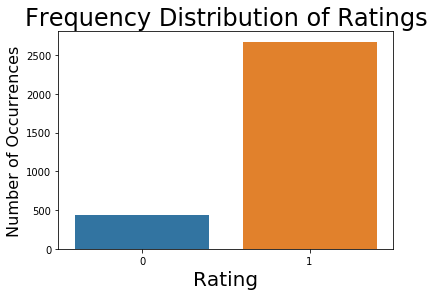

In [12]:
view = sns.countplot(x="effectiveness", data=train_data)
view.set_xticklabels(view.get_xticklabels())
plt.title('Frequency Distribution of Ratings', fontsize = 24)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Rating', fontsize=20)
plt.show()

## As we can see, there is lot of imbalance in train data, one of the tactics of combating imbalanced classes is using Decision Tree algorithms, so, we are using Random Forest classifier to learn imbalanced data and set class_weight=balanced .

## Split dataset for modelling 

In [13]:
X_train, X_test, y_train, y_test = [train_data.benefitsReview_lemma,test_data.benefitsReview_lemma,
                                    train_data.effectiveness,test_data.effectiveness]

# Building Model Pipeline and Tuning for better accuracy

First, define a function to print out the accuracy score.

In [14]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

To have efficient sentiment analysis or solving any NLP problem, we need a lot of features. Its not easy to figure out the exact number of features are needed. So we are going to try, 5,000 to 10,000. And print out accuracy scores associate with the number of features.

In [25]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
tfidf = TfidfVectorizer()
n_features = np.arange(5000,10000,1000)
def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stopwords, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [26]:
print("Result for bigram without stop words (CountVectorization)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=cv,ngram_range=(1, 2))

Result for bigram without stop words (CountVectorization)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


Test result for 5000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy score: 87.93%
Test result for 6000 features
accuracy score: 88.13%
Test result for 7000 features
accuracy score: 87.16%
Test result for 8000 features
accuracy score: 87.36%
Test result for 9000 features
accuracy score: 88.32%


## Confusion Matrix 

In [28]:
cv = CountVectorizer(max_features=9000,ngram_range=(1, 2))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)


[[ 71  87]
 [ 42 836]]


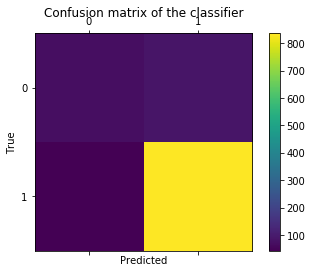

In [29]:
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Classification Report

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.45      0.52       158
           1       0.91      0.95      0.93       878

   micro avg       0.88      0.88      0.88      1036
   macro avg       0.77      0.70      0.73      1036
weighted avg       0.86      0.88      0.87      1036



# Chi-Squared for Feature Selection

We will calculate the Chi square scores for all the features and visualize the top 20, here terms or words or N-grams are features, and positive and negative are two classes. given a feature X, we can use Chi square test to evaluate its importance to distinguish the class.

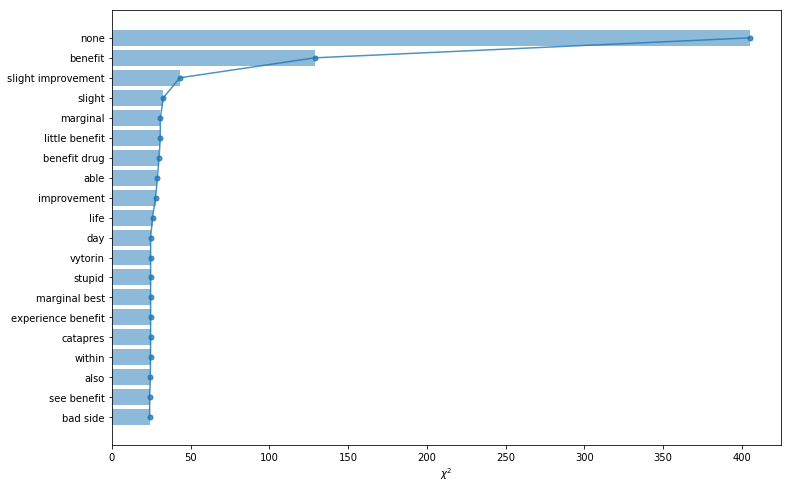

In [31]:
X = cv.fit_transform(X_train)
chi2score = chi2(X,y_train)[0]
%matplotlib inline
plt.figure(figsize=(12,8))
scores = list(zip(cv.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show()